In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



Import data into environment

In [2]:
df_final = pd.read_csv('final_data.csv')

In [3]:
#set max columns
pd.options.display.max_columns = None

In [4]:
df_final

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,temp_Barcelona,temp_min_Barcelona,temp_max_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,snow_3h_Barcelona,clouds_all_Barcelona,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,snow_3h_Bilbao,clouds_all_Bilbao,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,snow_3h_Madrid,clouds_all_Madrid,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,snow_3h_Seville,clouds_all_Seville,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia,hour,weekday,month,business hour,weekend,season
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,298.343515,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41,8.475,8.475,8.475,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,-3.493,-3.493,-3.493,1036.0,97.0,0.0,226.0,0.0,0.0,0.0,-5.825,-5.825,-5.825,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.225,0.225,0.225,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,-2.675,-2.675,-2.675,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,23.0,2.0,12.0,0.0,0,fall
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,298.343515,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92,8.475,8.475,8.475,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,-3.386,-3.386,-3.386,1035.0,97.0,0.0,229.0,0.0,0.0,0.0,-5.825,-5.825,-5.825,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.225,0.225,0.225,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,-2.675,-2.675,-2.675,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0,winter
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,298.343515,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48,8.136,8.136,8.136,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,-3.898,-3.898,-3.898,1036.0,97.0,1.0,224.0,0.0,0.0,0.0,-6.964,-6.964,-6.964,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.936,0.936,0.936,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,-3.464,-3.464,-3.464,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0,winter
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,298.343515,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32,8.136,8.136,8.136,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,-3.947,-3.947,-3.947,1035.0,97.0,1.0,225.0,0.0,0.0,0.0,-6.964,-6.964,-6.964,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.936,0.936,0.936,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,-3.464,-3.464,-3.464,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0,winter
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,298.343515,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04,8.136,8.136,8.136,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,-3.664,-3.664,-3.664,1035.0,97.0,1.0,221.0,0.0,0.0,0.0,-6.964,-6.964,-6.964,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.936,0.936,0.936,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,-3.464,-3.464,-3.464,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,3.0,3.0,1.0,0.0,0,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,297.0,0.0

# Feature Engineering

Creating a new feature of finding the difference of max and min temperatures per hour

In [5]:
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for i in range(len(df_final)):
    position = df_final.index[i]
    for city in cities:
        temp_max = df_final.loc[position, 'temp_max_{}'.format(city)]
        temp_min = df_final.loc[position, 'temp_min_{}'.format(city)]
        df_final.loc[position, 'temp_range_{}'.format(city)] = abs(temp_max - temp_min)

Taking into account the population of each cities, we create weighted temperature features


In [6]:
# Calculate the weight of every city

total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000

weight_Madrid = 6155116 / total_pop
weight_Barcelona = 5179243 / total_pop
weight_Valencia = 1645342 / total_pop
weight_Seville = 1305342 / total_pop
weight_Bilbao = 987000 / total_pop

In [7]:
cities_weights = {'Madrid': weight_Madrid,
                  'Barcelona': weight_Barcelona,
                  'Valencia': weight_Valencia,
                  'Seville': weight_Seville,
                  'Bilbao': weight_Bilbao}

In [8]:
# Generate 'temp_weighted' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    temp_weighted = 0
    for city in cities:
        temp = df_final.loc[position, 'temp_{}'.format(city)]
        temp_weighted += temp * cities_weights.get('{}'.format(city))
    df_final.loc[position, 'temp_weighted'] = temp_weighted

Generating a new feature which accounts for all the coal generation

In [9]:
df_final['generation coal all'] = df_final['generation fossil hard coal'] + df_final['generation fossil brown coal/lignite']

# Scaling

In [10]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

In [11]:

df_final['time'] = pd.to_datetime(df_final['time'], utc=True, infer_datetime_format=True)
df_final = df_final.set_index('time')

In [12]:
df_final['season'] = df_final['season'].map({'spring': 1, 'summer': 2, 'fall': 3, 'winter': 4})

In [13]:
X = df_final[df_final.columns.drop('price actual')].values
y = df_final['price actual'].values

y = y.reshape(-1, 1)

In [14]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [15]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [16]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

# Principal Component Analysis

In [17]:
pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])

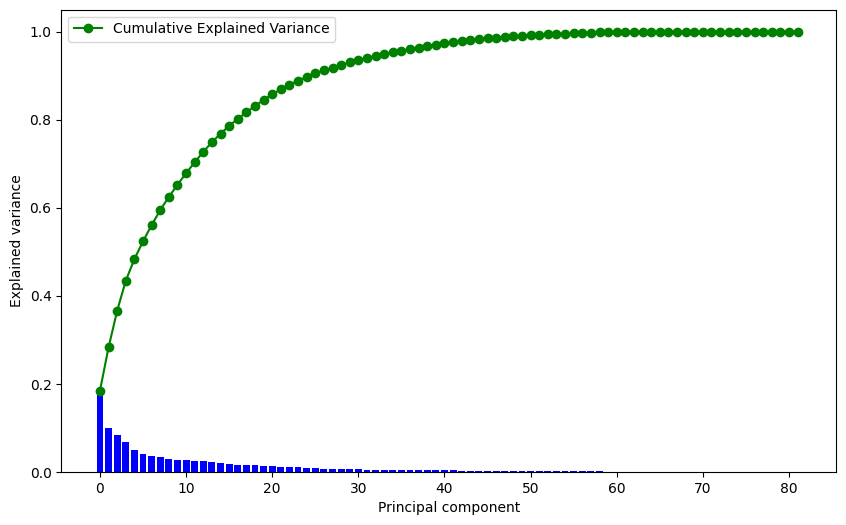

In [18]:
num_components = len(pca.explained_variance_ratio_)
colors = ['blue', 'orange', 'green', 'red', 'purple','pink','cyan','black']

plt.figure(figsize=(10, 6))

# Bar plot for individual explained variance
plt.bar(np.arange(num_components), pca.explained_variance_ratio_, color='blue')

# Line plot for cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='green', marker='o', label='Cumulative Explained Variance')

plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.legend()

plt.show()

In [19]:
pca = PCA(n_components=0.80)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

In [20]:
X_pca.shape

(35064, 17)

# Creating a function which incorporates data of past 24 hours for every hour, by creating first a 3-D array including the time of 24 hours + 18 features. Then converting it to 2-D to use further use

In [21]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24
future_target = 0

In [22]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [23]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history,
                                     future_target, step=1, single_step=True)

In [24]:
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history,
                                 future_target, step=1, single_step=True)

In [25]:
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history,
                                   future_target, step=1, single_step=True)

In [26]:
batch_size = 32
buffer_size = 1000

In [27]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [28]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [29]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

#Electricity Price Forecasting

In [30]:
def plot_model_rmse_and_loss(history):

    # Evaluate train and validation accuracies and losses

    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Visualize epochs vs. train and validation accuracies and losses

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.show()

# XGBoost

In [31]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

In [32]:
param = {'eta': 0.03, 'max_depth': 180,
         'subsample': 1.0, 'colsample_bytree': 0.95,
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse',
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
dtest = xgb.DMatrix(X_test_xgb, y_test)
eval_list = [(dtrain, 'train'), (dval, 'eval')]

xgb_model = xgb.train(param, dtrain, 180, eval_list, early_stopping_rounds=3)



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:28:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:28:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.19520	eval-rmse:0.16943
[1]	train-rmse:0.18985	eval-rmse:0.16487
[2]	train-rmse:0.18468	eval-rmse:0.16048
[3]	train-rmse:0.17965	eval-rmse:0.15623
[4]	train-rmse:0.17482	eval-rmse:0.15221
[5]	train-rmse:0.17013	eval-rmse:0.14824
[6]	train-rmse:0.16561	eval-rmse:0.14445
[7]	train-rmse:0.16124	eval-rmse:0.14076
[8]	train-rmse:0.15701	eval-rmse:0.13717
[9]	train-rmse:0.15291	eval-rmse:0.13381
[10]	train-rmse:0.14898	eval-rmse:0.13047
[11]	train-rmse:0.14517	eval-rmse:0.12722
[12]	train-rmse:0.14145	eval-rmse:0.12414
[13]	train-rmse:0.13791	eval-rmse:0.12126
[14]	train-rmse:0.13468	eval-rmse:0.11870
[15]	train-rmse:0.13134	eval-rmse:0.11582
[16]	train-rmse:0.12811	eval-rmse:0.11321
[17]	train-rmse:0.12499	eval-rmse:0.11060
[18]	train-rmse:0.12196	eval-rmse:0.10805
[19]	train-rmse:0.11910	eval-rmse:0.10566
[20]	train-rmse:0.11632	eval-rmse:0.10334
[21]	train-rmse:0.11368	eval-rmse:0.10114
[22]	train-rmse:0.11125	eval-rmse:0.09926
[23]	train-rmse:0.10871	eval-rmse:0.09721
[2

In [33]:
xgb_model.eval

<bound method Booster.eval of <xgboost.core.Booster object at 0x7aac6a37b3d0>>

In [34]:
forecast = xgb_model.predict(dtest)
xgb_forecast = forecast.reshape(-1, 1)

xgb_forecast_inv = scaler_y.inverse_transform(xgb_forecast)

rmse_xgb = sqrt(mean_squared_error(y_test_inv, xgb_forecast_inv))
print('RMSE of hour-ahead electricity price XGBoost forecast: {}'
      .format(round(rmse_xgb, 3)))

RMSE of hour-ahead electricity price XGBoost forecast: 2.987


In [35]:
metrics_df = pd.DataFrame(columns=['Model', 'MAPE', 'RMSE', 'MAE', 'R2'])


def metrics(model_name,y_true, y_pred):
    y_true = y_true.reshape(-1,1)
    y_pred = y_pred.reshape(-1,1)

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = sqrt(np.mean((y_true - y_pred)**2))
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)

    print('MAPE: %.2f' % mape)
    print('RMSE: %.2f' % rmse)
    print('MAE: %.2f' % mae)
    print('R2: %.2f' % r2)
    # Store metrics in the DataFrame
    global metrics_df
    metrics_df = metrics_df.append({'Model': model_name, 'MAPE': mape, 'RMSE': rmse, 'MAE': mae, 'R2': r2}, ignore_index=True)
    # Print the first five values with labels

    compare_data = pd.DataFrame({'actual': y_true.flatten(), 'forecast': y_pred.flatten()})
    print(compare_data.head())


    # Create a line graph using Plotly Express
    #plot df using plotly
    fig = px.line(compare_data, y=['actual', 'forecast'],x=df_final[31080:].index , title='Actual vs Forecasted Prices on the Unseen Data(test)', labels={'value': 'Actual Prices', 'time': 'Date'})
    fig.show()

In [36]:
df_final[['price actual']][31080:].shape

(3984, 1)

In [37]:
df_resulttt = pd.DataFrame({'Actual': y_test_inv.flatten(), 'Forecast': xgb_forecast_inv.flatten()}, index=df_final[31080:].index)



In [38]:
#save df_resulttt to csv
df_resulttt.to_csv('forecast_results.csv')

In [39]:
metrics('XGBoost',y_test_inv,xgb_forecast_inv)

MAPE: 2.79
RMSE: 2.99
MAE: 1.95
R2: 0.87
   actual   forecast
0   67.08  63.613888
1   65.19  62.248875
2   62.87  61.773457
3   63.02  60.011440
4   64.50  61.766949


<ipython-input-35-839106ab6f5e>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'Model': model_name, 'MAPE': mape, 'RMSE': rmse, 'MAE': mae, 'R2': r2}, ignore_index=True)


MAPE: 2.79
RMSE: 2.99
MAE: 1.95
R2: 0.87

Residual Plot

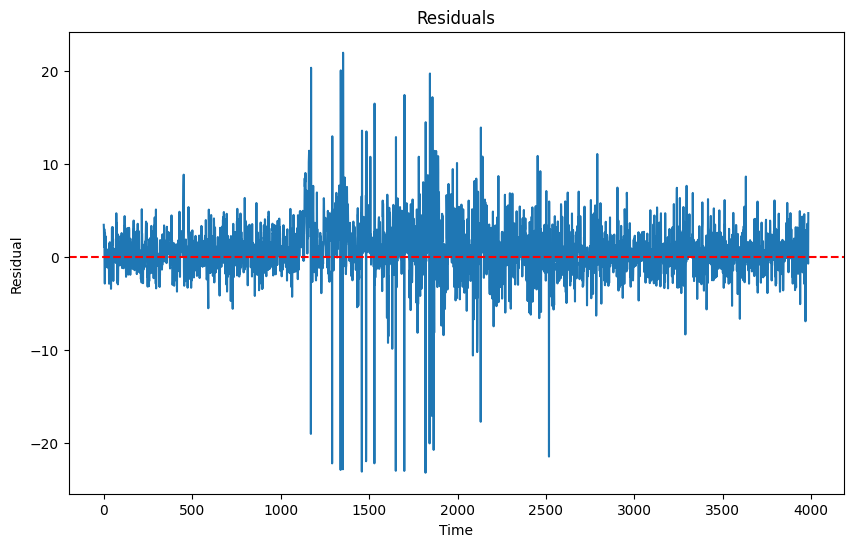

In [40]:
def plot_residuals(actuals, forecast, title='Residuals'):
    residuals = actuals - forecast
    plt.figure(figsize=(10, 6))
    plt.plot(residuals)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

plot_residuals(y_test_inv, xgb_forecast_inv)

Distribution of Residuals

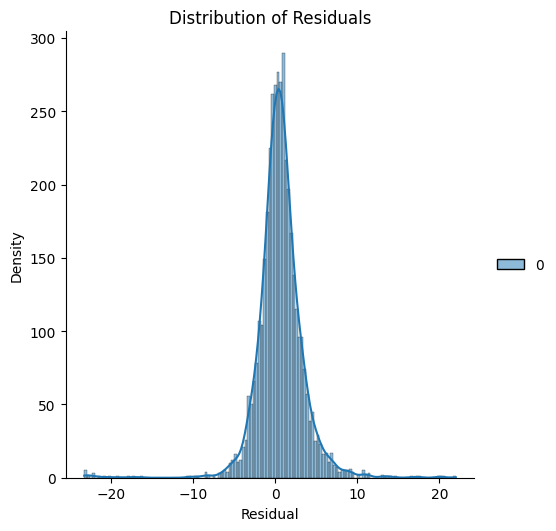

In [41]:
def plot_residuals_distribution(residuals):
    sns.displot(residuals, kde=True)
    plt.title('Distribution of Residuals')
    plt.xlabel('Residual')
    plt.ylabel('Density')
    plt.show()

residuals = y_test_inv - xgb_forecast_inv
plot_residuals_distribution(residuals)

Checking overfitting: the train RMSE is not significantly lower than test RMSE, hence there seems to be no overfitting

In [42]:



train_preds_1 = xgb_model.predict(dtrain)

# Predict on the test set
test_preds_1 = xgb_model.predict(dtest)

# Calculate RMSE for training and test sets
train_rmse_1= sqrt(mean_squared_error(y_train, train_preds_1))
test_rmse_1 = sqrt(mean_squared_error(y_test, test_preds_1))

# Output RMSE values to check for overfitting
print(f"XGBoost Train RMSE: {train_rmse_1:.4f}")
print(f"XGBoost Test RMSE: {test_rmse_1:.4f}")

# If the train RMSE is significantly lower than the test RMSE, it may indicate overfitting


XGBoost Train RMSE: 0.0484
XGBoost Test RMSE: 0.0526


# LSTM_CNN

In [43]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=500, kernel_size=2,
           strides=1, padding='causal',
           activation='relu',
           input_shape=input_shape),
    LSTM(500, return_sequences=True),
    Flatten(),
    Dense(300, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [44]:
history = multivariate_cnn_lstm.fit(train, epochs=200,
                                    validation_data=validation,
                                    callbacks=[early_stopping,
                                               model_checkpoint])

Epoch 1/200
845/845 [==============================] - 14s 10ms/step - loss: 0.0470 - root_mean_squared_error: 0.2167 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



Epoch 2/200
845/845 [==============================] - 8s 10ms/step - loss: 0.0089 - root_mean_squared_error: 0.0943 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727
Epoch 3/200
845/845 [==============================] - 9s 10ms/step - loss: 0.0062 - root_mean_squared_error: 0.0788 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0635
Epoch 4/200
845/845 [==============================] - 8s 10ms/step - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0621
Epoch 5/200
845/845 [==============================] - 8s 9ms/step - loss: 0.0052 - root_mean_squared_error: 0.0719 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0642
Epoch 6/200
845/845 [==============================] - 9s 10ms/step - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0613
Epoch 7/200
845/845 [==============================] - 9s 10ms/step - loss: 0.0048 - root_mean_squared_error: 0.0696 - val_loss: 0.

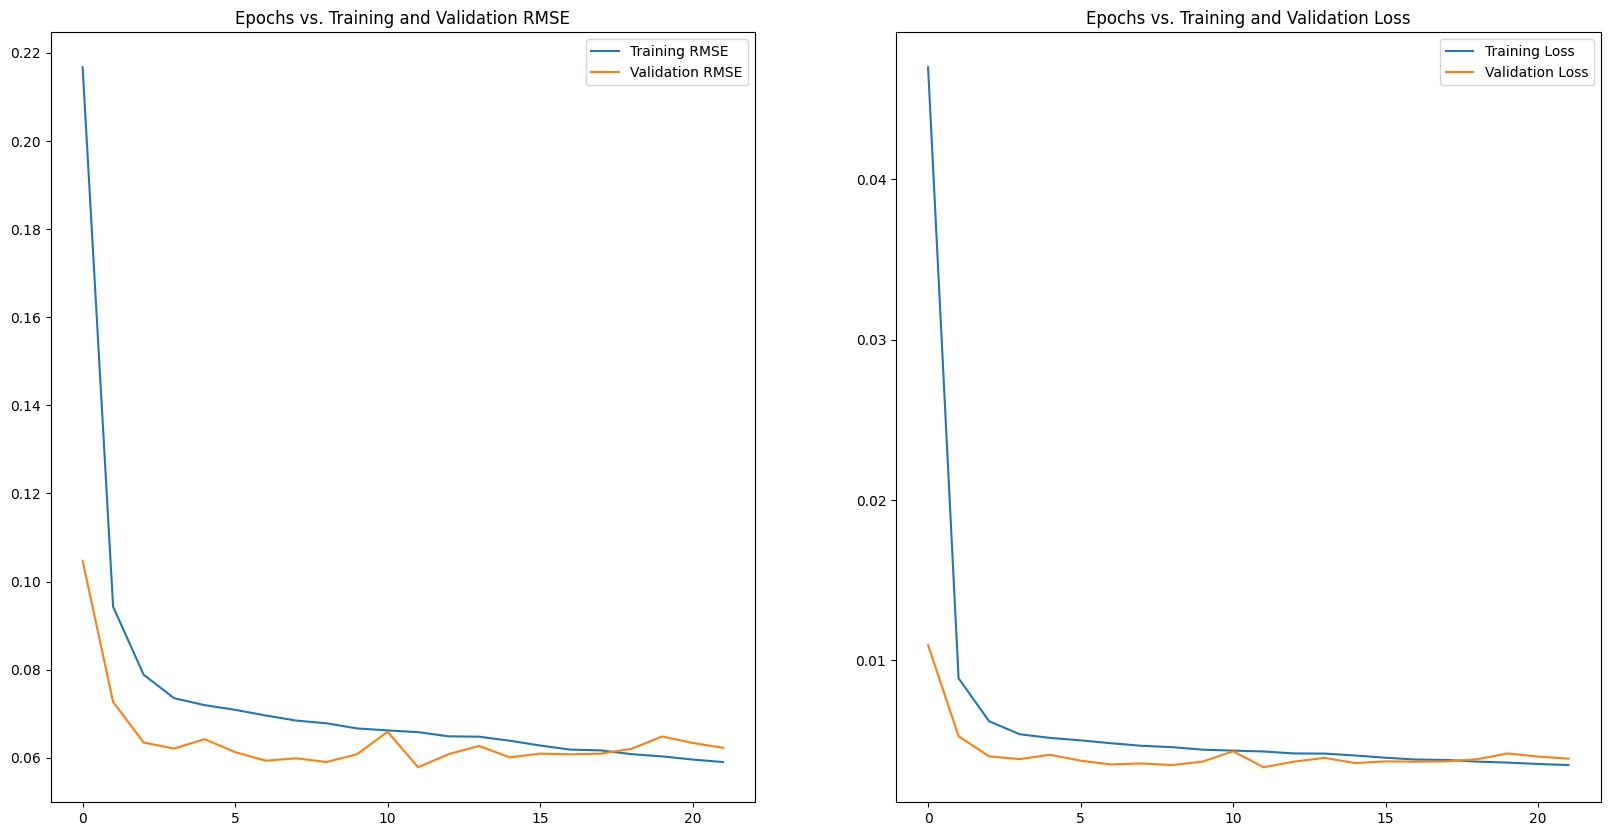

In [45]:
plot_model_rmse_and_loss(history)

In [46]:
from tensorflow.keras.utils import plot_model


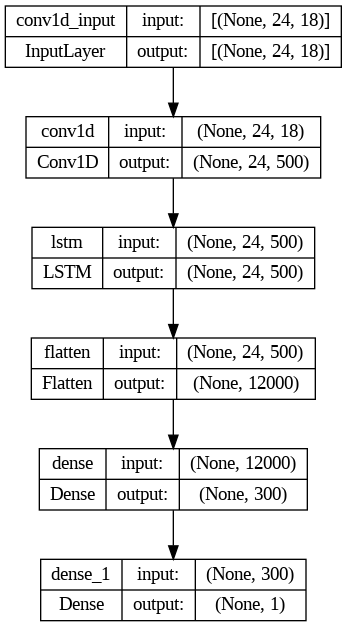

In [47]:
plot_model(multivariate_cnn_lstm, to_file='model_architecture.png', show_shapes=True)


In [48]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_inv,
                                             multivariate_cnn_lstm_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN-`LSTM forecast: {}'
      .format(round(rmse_mult_cnn_lstm, 3)))

125/125 [==============================] - 1s 3ms/step
RMSE of hour-ahead electricity price multivariate CNN-`LSTM forecast: 3.416


In [49]:
metrics('CNN-LSTM',y_test_inv,multivariate_cnn_lstm_forecast)

MAPE: 3.46
RMSE: 3.42
MAE: 2.41
R2: 0.83
   actual   forecast
0   67.08  64.828514
1   65.19  63.472076
2   62.87  64.856194
3   63.02  62.741428
4   64.50  63.489838


<ipython-input-35-839106ab6f5e>:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



MAPE: 3.18
RMSE: 3.26
MAE: 2.17
R2: 0.84

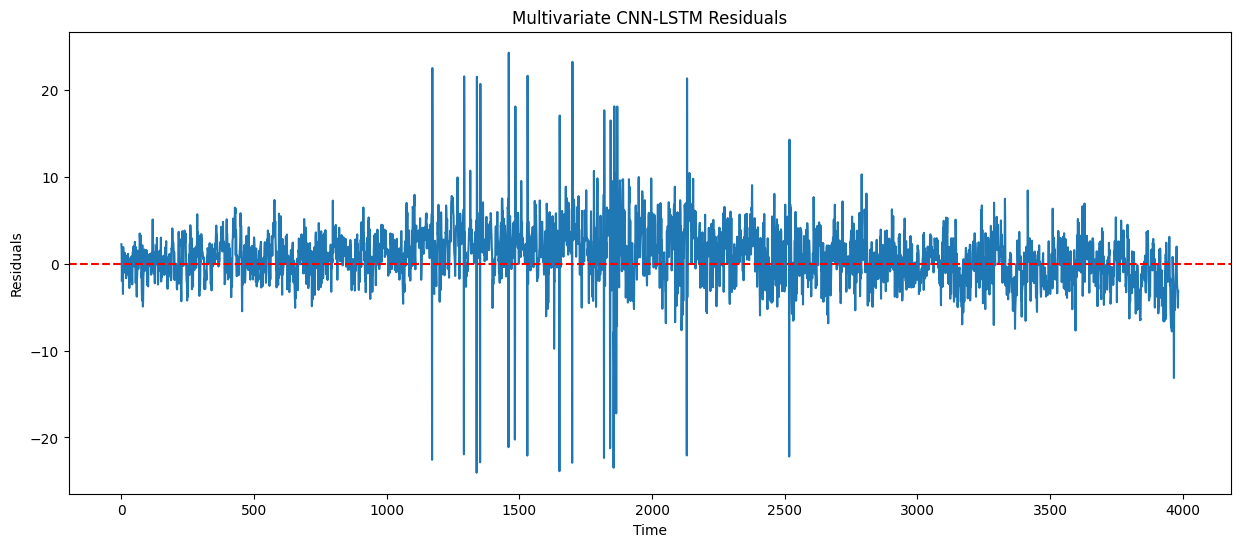

In [50]:
def plot_residuals(actuals, predictions, title='Residuals'):
    residuals = actuals.flatten() - predictions.flatten()
    plt.figure(figsize=(15, 6))
    plt.plot(residuals)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.axhline(y=0, linestyle='--', color='red')
    plt.show()

plot_residuals(y_test_inv, multivariate_cnn_lstm_forecast, 'Multivariate CNN-LSTM Residuals')


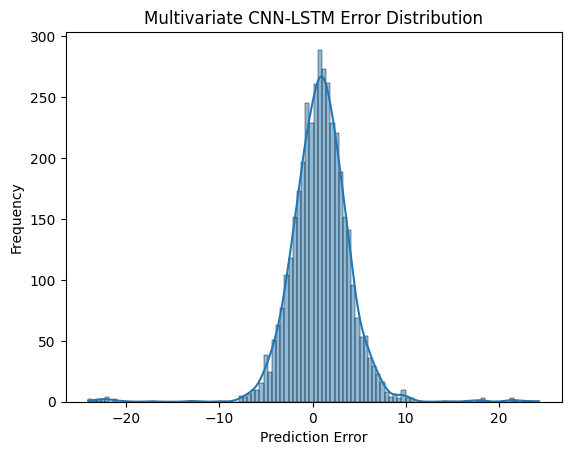

In [51]:
def plot_error_distribution(actuals, predictions, title='Error Distribution'):
    errors = actuals.flatten() - predictions.flatten()
    sns.histplot(errors, kde=True)
    plt.title(title)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.show()

plot_error_distribution(y_test_inv, multivariate_cnn_lstm_forecast, 'Multivariate CNN-LSTM Error Distribution')


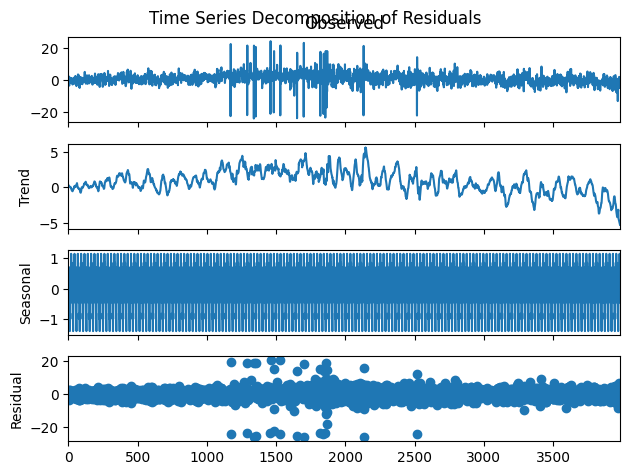

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_time_series(residuals, period=24, model='additive', title='Time Series Decomposition of Residuals'):
    decomposition = seasonal_decompose(residuals, model=model, period=period, extrapolate_trend='freq')
    fig = decomposition.plot()
    plt.suptitle(title)
    plt.show()

residuals = y_test_inv.flatten() - multivariate_cnn_lstm_forecast.flatten()
decompose_time_series(residuals)


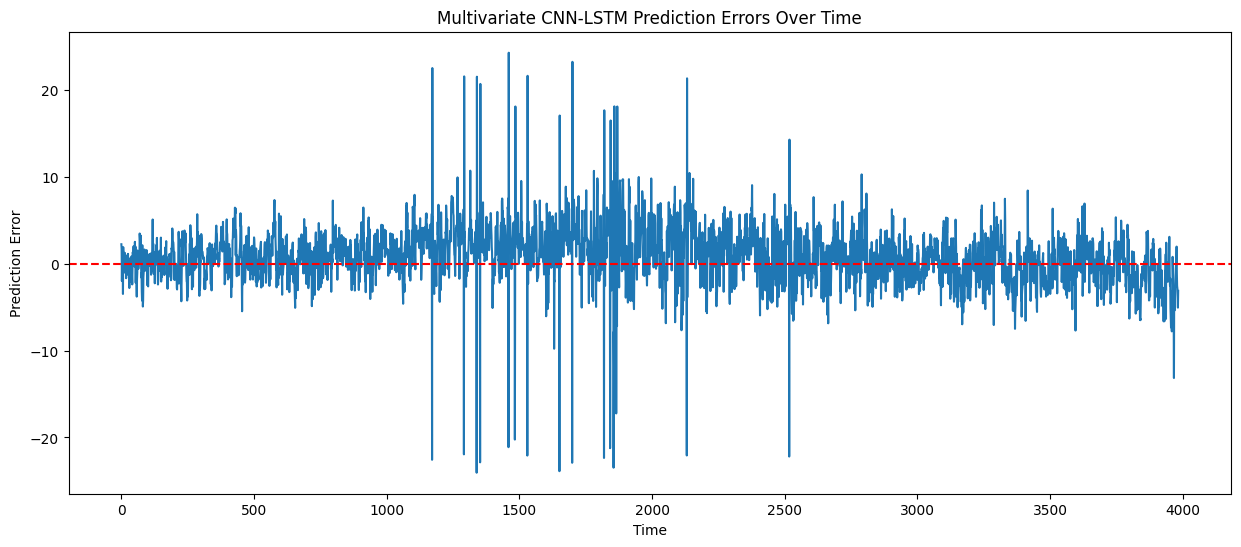

In [53]:
def plot_error_time_series(actuals, predictions, title='Prediction Errors Over Time'):
    errors = actuals.flatten() - predictions.flatten()
    plt.figure(figsize=(15, 6))
    plt.plot(errors)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Prediction Error')
    plt.axhline(y=0, linestyle='--', color='red')
    plt.show()

plot_error_time_series(y_test_inv, multivariate_cnn_lstm_forecast, 'Multivariate CNN-LSTM Prediction Errors Over Time')


<Figure size 1000x400 with 0 Axes>

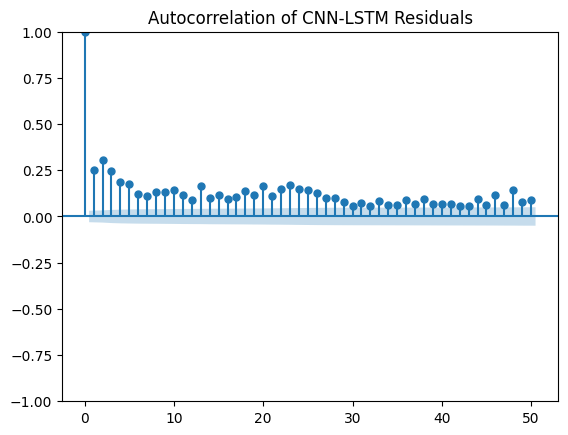

In [54]:
from statsmodels.graphics.tsaplots import plot_acf

def plot_autocorrelation(residuals, lags=50, title='Autocorrelation Plot'):
    plt.figure(figsize=(10, 4))
    plot_acf(residuals, lags=lags)
    plt.title(title)
    plt.show()

plot_autocorrelation(residuals, lags=50, title='Autocorrelation of CNN-LSTM Residuals')


Adding more layers

In [55]:


multivariate_cnn_lstm2 = tf.keras.models.Sequential([
    Conv1D(filters=500, kernel_size=2, strides=1, padding='causal', activation='relu', input_shape=input_shape),
    Conv1D(filters=300, kernel_size=2, strides=1, padding='causal', activation='relu'),
    LSTM(500, return_sequences=True),
    LSTM(300, return_sequences=False),  # Note the change here for the last LSTM layer
    Flatten(),
    Dense(300, activation='relu'),
    Dropout(0.2),  # Adding dropout to help with regularization
    Dense(100, activation='relu'),  # An additional Dense layer
    Dense(1)
])


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm2.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)

multivariate_cnn_lstm2.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [56]:
history = multivariate_cnn_lstm2.fit(train, epochs=200,
                                    validation_data=validation,
                                    callbacks=[early_stopping,
                                               model_checkpoint])

Epoch 1/200
845/845 [==============================] - 18s 13ms/step - loss: 0.0214 - root_mean_squared_error: 0.1385 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0995
Epoch 2/200
  6/845 [..............................] - ETA: 8s - loss: 0.0237 - root_mean_squared_error: 0.1540 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



845/845 [==============================] - 10s 12ms/step - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0817
Epoch 3/200
845/845 [==============================] - 10s 12ms/step - loss: 0.0060 - root_mean_squared_error: 0.0777 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0662
Epoch 4/200
845/845 [==============================] - 10s 12ms/step - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0638
Epoch 5/200
845/845 [==============================] - 10s 12ms/step - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0590
Epoch 6/200
845/845 [==============================] - 10s 12ms/step - loss: 0.0050 - root_mean_squared_error: 0.0708 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0664
Epoch 7/200
845/845 [==============================] - 10s 12ms/step - loss: 0.0049 - root_mean_squared_error: 0.0697 - val_loss: 0.0035 

In [57]:
multivariate_cnn_lstm2 = tf.keras.models.load_model('multivariate_cnn_lstm2.h5')

forecast = multivariate_cnn_lstm2.predict(X_test)
multivariate_cnn_lstm2_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn_lstm2 = sqrt(mean_squared_error(y_test_inv,
                                             multivariate_cnn_lstm2_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN-`LSTM2 forecast: {}'
      .format(round(rmse_mult_cnn_lstm2, 3)))

125/125 [==============================] - 2s 5ms/step
RMSE of hour-ahead electricity price multivariate CNN-`LSTM2 forecast: 3.218


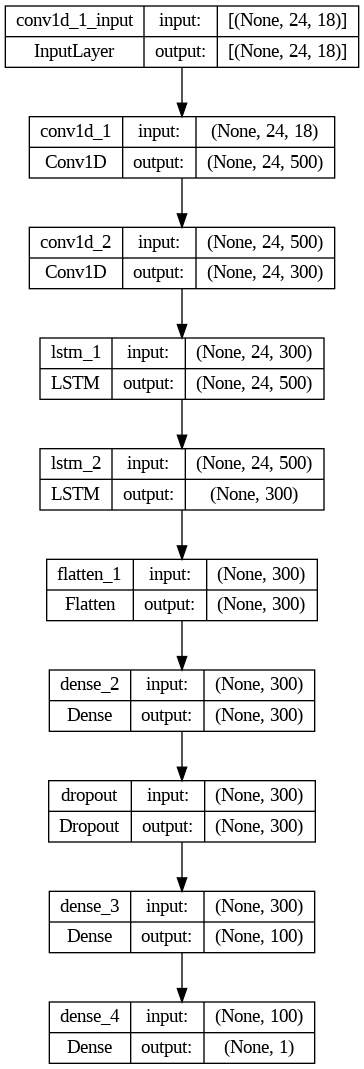

In [58]:
plot_model(multivariate_cnn_lstm2, to_file='model_architecture.png', show_shapes=True)


In [59]:
metrics('Large CNN-LSTM',y_test_inv,multivariate_cnn_lstm2_forecast)

MAPE: 3.15
RMSE: 3.22
MAE: 2.19
R2: 0.85
   actual   forecast
0   67.08  65.744858
1   65.19  64.309723
2   62.87  64.621078
3   63.02  62.824234
4   64.50  63.904961


<ipython-input-35-839106ab6f5e>:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



MAPE: 3.78
RMSE: 3.65
MAE: 2.67
R2: 0.80

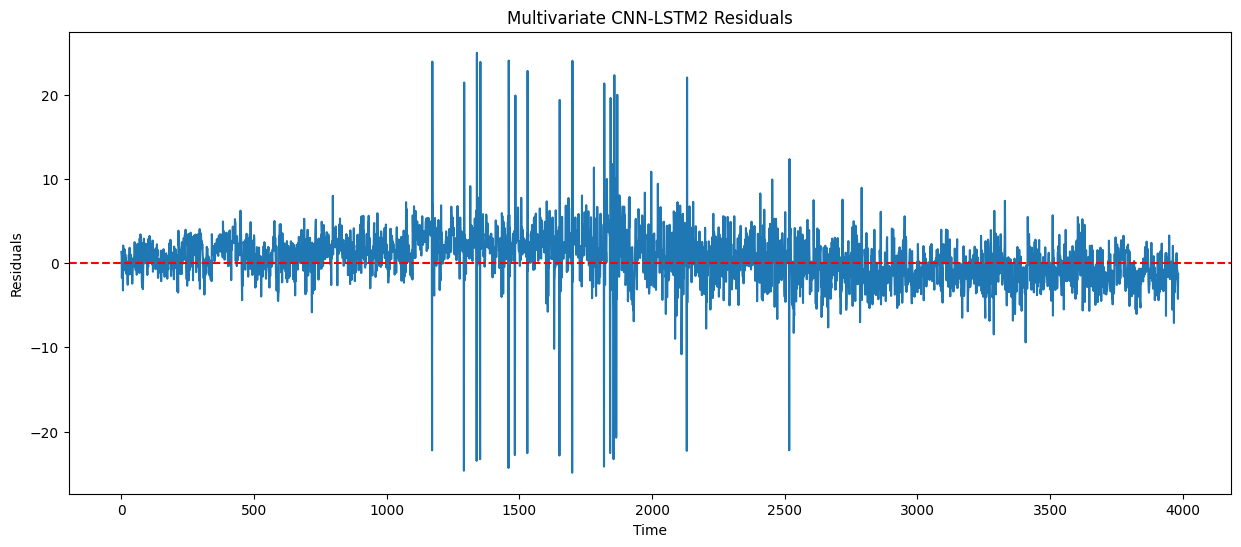

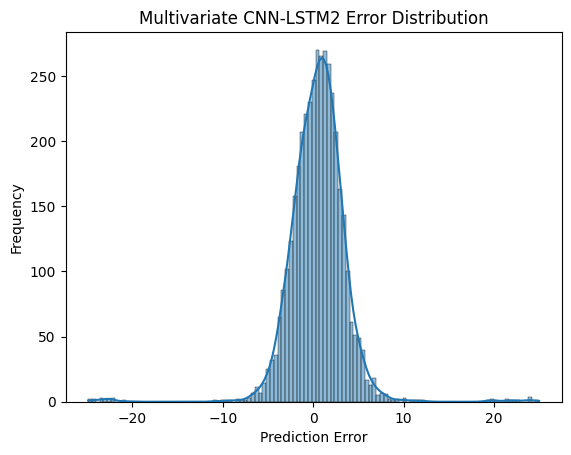

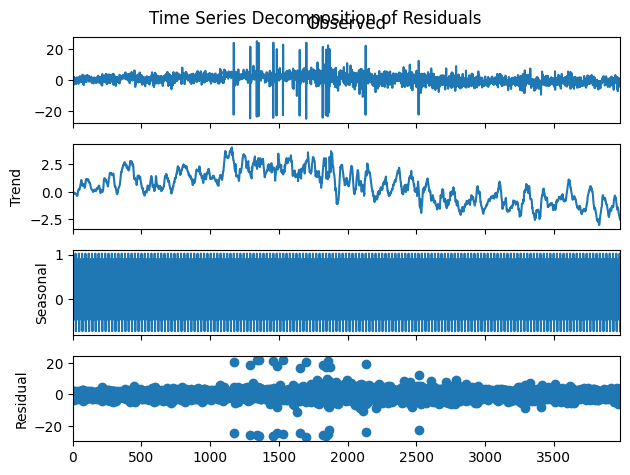

NameError: name 'plot_learning_curve' is not defined

In [60]:
plot_residuals(y_test_inv, multivariate_cnn_lstm2_forecast, 'Multivariate CNN-LSTM2 Residuals')
plot_error_distribution(y_test_inv, multivariate_cnn_lstm2_forecast, 'Multivariate CNN-LSTM2 Error Distribution')
residuals = y_test_inv.flatten() - multivariate_cnn_lstm2_forecast.flatten()
decompose_time_series(residuals)
plot_learning_curve(history)
plot_error_time_series(y_test_inv, multivariate_cnn_lstm2_forecast, 'Multivariate CNN-LSTM2 Prediction Errors Over Time')
plot_autocorrelation(residuals, lags=50, title='Autocorrelation of CNN-LSTM2 Residuals')

# Best Model

In [61]:
metrics_df.sort_values('MAPE' )

,Model,MAPE,RMSE,MAE,R2
0,XGBoost,2.792055,2.986713,1.946685,0.867672
2,Large CNN-LSTM,3.145395,3.218300,2.191477,0.846355
1,CNN-LSTM,3.457973,3.415545,2.412964,0.826944


# The best model out of all three is XGBoost. This is our MVP